<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax

In [3]:
import jax
jax.config.update("jax_enable_x64", True)

In [4]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc, time_stepping, shard_utils
from jax_ib.base import grids, interpolation, fast_diagonalization, boundaries, pressure as prs, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax.tree_util import register_pytree_node_class, register_dataclass, register_pytree_node
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax.experimental.pjit import pjit
from jax_ib.base import array_utils
import jax
from jax.sharding import NamedSharding
from jax.experimental.custom_partitioning import custom_partitioning
from jax.experimental.pjit import pjit
from jax.sharding import PartitionSpec as P
from jax.sharding import Mesh
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
from jax_ib.base import xfft, utils
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
import numpy as np
import jax_ib.base.fft as fft
import scipy as sp
from scipy import linalg
from jax_ib.base import fast_diagonalization as fdiag

In [6]:
N = 128
M = 8
α, β = 1,1
As = [[None for _ in range(M)] for _ in range(M)]
subA = np.exp(-2*np.pi*1j*np.outer(np.arange(N//M), np.arange(N//M))/N)
exp =  np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
cols = [ np.exp(-2*np.pi*1j/N*j*(N//M) * np.arange(N//M)) for j in range(M)]
rows = [np.exp(-2*np.pi*1j/N*i*(N//M) * np.arange(N//M)) for i in range(M)]
x = np.random.rand(N).astype(np.complex64)
result = []
for i in range(M):
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        As[i][j] = cols[j][:,None]*subA * rows[i][None,:] * phase
for i in range(M):
    temp = np.zeros(N//M, dtype=complex)
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        temp += cols[j]*np.fft.fft(rows[i] *x[j*(N//M):(j+1)*(N//M)], N)[:(N//M)]* phase
    result.append(temp)
    
A = np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
y1 = np.fft.fft(x)
y2 = np.concatenate(result)
A2 = np.concatenate([np.concatenate(As[m], axis=1) for m in range(M)], axis=0)

In [19]:
mesh = jax.make_mesh(axis_shapes = (2,2), axis_names = ('i','j'))
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=1e-4        # time step 

num_boundaries = 4 # in two dimensions there are 4 boundaries
K = 10
L = 20.0
domain = ((0.0,L),(0.0,L))
size=(2**K,2**K)
dtype = jnp.float64
grid = grids.Grid(size, domain=domain, device_mesh = mesh, periods = (L,L), dtype=dtype)

In [6]:
dist_initialize = shard_map(shard_utils.dist_initialize, mesh=mesh, in_specs = (P('i','j'), None), out_specs=(P('i','j'), (P('i','j'),  P('i','j'))))


In [7]:
global_pressure, global_velocities = dist_initialize(np.arange(4).reshape(2,2), grid)


In [20]:
all_variables = pc.All_Variables(velocities,pressure,[0],0,[0], 0.0)

NameError: name 'velocities' is not defined

In [22]:
all_variables

All_Variables(velocity=(
GridVariable
     GridArray
        Array([[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)
        Grid(shape=(1024, 1024), step=(Array(0.01953125, dtype=float64), Array(0.01953125, dtype=float64)), domain=((Array(0., dtype=float64), Array(20., dtype=float64)), (Array(0., dtype=float64), Array(20., dtype=float64))), periods=(20.0, 20.0), device_mesh=Mesh(device_ids=array([[0, 1],
               [2, 3]]), axis_names=('i', 'j')))
        offset: (1.0, 0.5)
    Boundary Condition: ConstantBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0)), boundary_fn=[<function <lambda> at 0x7f3b0c36ba60>, <function <lambda> at 0x7f3b0c36bce0>, <function <lambda> at 0x7f3b0

In [21]:
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

velocities = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.zeros_like(x, dtype=dtype), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

pressure = grids.GridVariable(
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x).astype(dtype), offset = grid.cell_center),  boundaries.get_pressure_bc_from_velocity(velocities) 
        ) 

all_variables = pc.All_Variables(velocities,pressure,[0],0,[0], 0.0)

In [8]:
def ellipse(geometry_params, ntheta=200):
    A = geometry_params[0]
    B = geometry_params[1]
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position + jnp.array([amplitude/2 * jnp.cos(2*jnp.pi*frequency*t), 0.0]) - jnp.array([amplitude/2, 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp

In [9]:
particle_geometry_param = jnp.array([[0.5,1.0]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])


In [10]:
eigvals = tuple([np.fft.fft(array_utils.laplacian_column(size, step)) for size, step in zip(grid.shape, grid.step)]) 
def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)    
    
explicit_update = equations.navier_stokes_explicit_terms(
    density=density, viscosity=viscosity, dt=dt,convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
surface_velocity = lambda f,x,y: convolution_functions.mesh_convolve(f,x,y,convolution_functions.gaussian, axis_names=['i','j'])


evolve = jax.jit(shard_map(time_stepping.evolve_navier_stokes_sharded, mesh=mesh, in_specs=(P('i','j'),(P('i','j'), P('i','j')),(P('i'), P('j')),P(),P(),None,None,None, None,None), 
         out_specs=(P('i','j'), (P('i','j'),  P('i','j')))),static_argnums = (4, 5,6,7,8,9))


In [11]:
p, v = global_pressure, global_velocities

In [12]:
ref_time = 0.0
inner_steps = 100

In [13]:
p, v = evolve(p, v,eigvals,ref_time, dt, 1, inner_steps, ellipse_position, explicit_update, surface_velocity)

In [14]:
p.data

Array([[0.9999948 , 0.9999948 , 0.9999948 , ..., 0.99999479, 0.99999479,
        0.99999479],
       [0.9999948 , 0.99999481, 0.99999481, ..., 0.99999479, 0.9999948 ,
        0.9999948 ],
       [0.99999481, 0.99999481, 0.99999482, ..., 0.9999948 , 0.9999948 ,
        0.9999948 ],
       ...,
       [0.99999478, 0.99999479, 0.99999479, ..., 0.99999477, 0.99999477,
        0.99999478],
       [0.99999479, 0.99999479, 0.99999479, ..., 0.99999478, 0.99999478,
        0.99999478],
       [0.99999479, 0.9999948 , 0.9999948 , ..., 0.99999478, 0.99999478,
        0.99999479]], dtype=float64)

In [56]:
uxs, uys = [np.array(global_velocities[0].data)], [np.array(global_velocities[1].data)]
ref_time = 0.0
inner_steps = 100
outer_steps = 10
for step in range(outer_steps):
    print(step)
    p, v = evolve(p, v,eigvals,ref_time, dt, 1, inner_steps, ellipse_position, explicit_update, surface_velocity)
    ref_time += inner_steps * dt
    uxs.append(v[0].data)
    uys.append(v[1].data)
p.data.block_until_ready()

0
1
2
3
4
5
6
7
8
9


Array([[0.99999365, 0.99999366, 0.99999366, ..., 0.99999364, 0.99999365,
        0.99999365],
       [0.99999366, 0.99999366, 0.99999367, ..., 0.99999365, 0.99999365,
        0.99999366],
       [0.99999367, 0.99999367, 0.99999368, ..., 0.99999365, 0.99999366,
        0.99999366],
       ...,
       [0.99999364, 0.99999364, 0.99999364, ..., 0.99999362, 0.99999363,
        0.99999363],
       [0.99999364, 0.99999365, 0.99999365, ..., 0.99999363, 0.99999363,
        0.99999364],
       [0.99999365, 0.99999365, 0.99999366, ..., 0.99999363, 0.99999364,
        0.99999364]], dtype=float64)

In [57]:
uxs[1]

Array([[-1.38194363e-05, -1.31242483e-05, -1.24302369e-05, ...,
        -1.59134404e-05, -1.52138940e-05, -1.45159388e-05],
       [-1.43256422e-05, -1.36142064e-05, -1.29039620e-05, ...,
        -1.64684786e-05, -1.57526402e-05, -1.50384075e-05],
       [-1.48305188e-05, -1.41029729e-05, -1.33766334e-05, ...,
        -1.70217727e-05, -1.62897807e-05, -1.55594088e-05],
       ...,
       [-1.22929914e-05, -1.16473763e-05, -1.10028918e-05, ...,
        -1.42380056e-05, -1.35881674e-05, -1.29398756e-05],
       [-1.28030958e-05, -1.21408181e-05, -1.14796864e-05, ...,
        -1.47981892e-05, -1.41316427e-05, -1.34666578e-05],
       [-1.33119158e-05, -1.26331139e-05, -1.19554732e-05, ...,
        -1.53566724e-05, -1.46735566e-05, -1.39920172e-05]],      dtype=float64)

In [44]:
def internal_post_processing(all_variables,dt):
    return all_variables

surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)

IBM_forcing = lambda velocities,t,dt: IBM_Force.immersed_boundary_force(velocities,
                                                                        [ellipse_position],
                                                                        convolution_functions.gaussian,
                                                                        surf_fn,
                                                                        t,
                                                                        dt)
inner_steps = 10
outer_steps = 10

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #compute the forcing term to update the particle
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))


In [45]:
actual = step_fn(all_variables)

In [46]:
np.linalg.norm(actual.velocity[1].data - v[1].data)

np.float64(7.629796707633521e-15)

In [30]:
v = tuple([np.array(_.data) for _ in v])

In [34]:
np.max(v[1].data), np.max(actual.velocity[1].data)

(Array(0.73457361, dtype=float64), Array(0.73457361, dtype=float64))

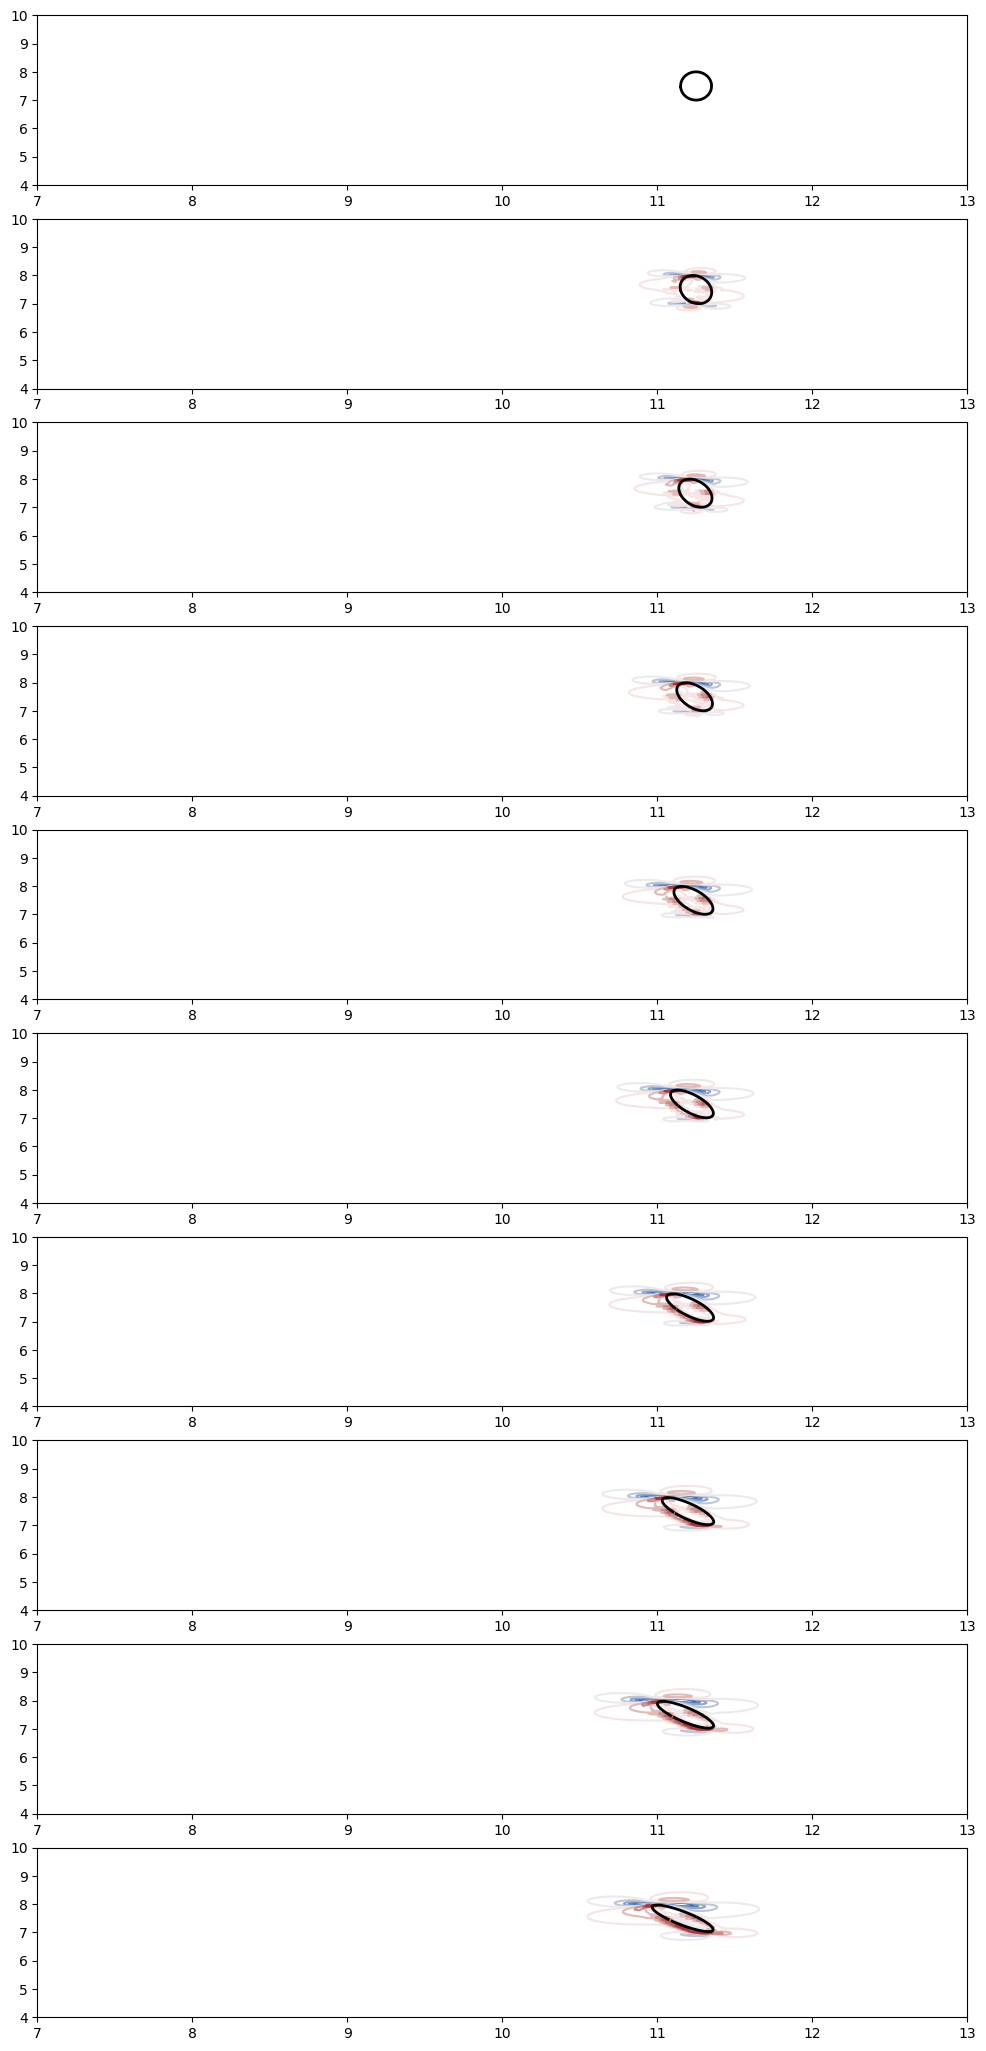

In [13]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid, 0), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid, 0), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps)

idx = 2
counter=0
for idx in range(outer_steps):
    current_t = trajectory.time[idx]
    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1

In [83]:
_vy[6]

array([[-9.00796616e-05+3.15048109e-18j, -8.96803917e-05+2.78324685e-18j,
        -8.92697573e-05+2.40287669e-18j, ...,
        -9.12070637e-05+4.80035954e-18j, -9.08432203e-05+4.38485791e-18j,
        -9.04673453e-05+3.29622672e-18j],
       [-8.99331209e-05-1.99814709e-18j, -8.95342681e-05-1.67871961e-18j,
        -8.91240725e-05-8.10457485e-19j, ...,
        -9.10594045e-05-2.47806283e-18j, -9.06959116e-05-2.38898853e-18j,
        -9.03204095e-05-2.45174079e-18j],
       [-8.97981445e-05+2.08614457e-18j, -8.93994874e-05+1.94162386e-18j,
        -8.89895099e-05+1.40584751e-18j, ...,
        -9.09239780e-05+7.97544977e-19j, -9.05606122e-05+1.19187053e-18j,
        -9.01852602e-05+1.44805302e-18j],
       ...,
       [-9.05888846e-05+4.00469572e-18j, -9.01870320e-05+3.52141215e-18j,
        -8.97737550e-05+3.03933332e-18j, ...,
        -9.17236621e-05+4.56258805e-18j, -9.13574239e-05+4.19387135e-18j,
        -9.09790899e-05+3.83892236e-18j],
       [-9.04075226e-05+1.86368579e-18j, -9.

In [129]:
outer_steps


10

In [66]:
uxs[2]

Array([[-4.22001790e-05, -4.14402249e-05, -4.06840064e-05, ...,
        -4.45038622e-05, -4.37318565e-05, -4.29640092e-05],
       [-4.36250638e-05, -4.28489530e-05, -4.20766186e-05, ...,
        -4.59774603e-05, -4.51891765e-05, -4.44050914e-05],
       [-4.50460318e-05, -4.42539045e-05, -4.34655942e-05, ...,
        -4.74467181e-05, -4.66422978e-05, -4.58421161e-05],
       ...,
       [-3.79024328e-05, -3.71917923e-05, -3.64847623e-05, ...,
        -4.00574291e-05, -3.93351096e-05, -3.86168248e-05],
       [-3.93388222e-05, -3.86116031e-05, -3.78880366e-05, ...,
        -4.15438057e-05, -4.08047820e-05, -4.00698348e-05],
       [-4.07714181e-05, -4.00277612e-05, -3.92877986e-05, ...,
        -4.30259637e-05, -4.22703781e-05, -4.15189101e-05]],      dtype=float64)

11


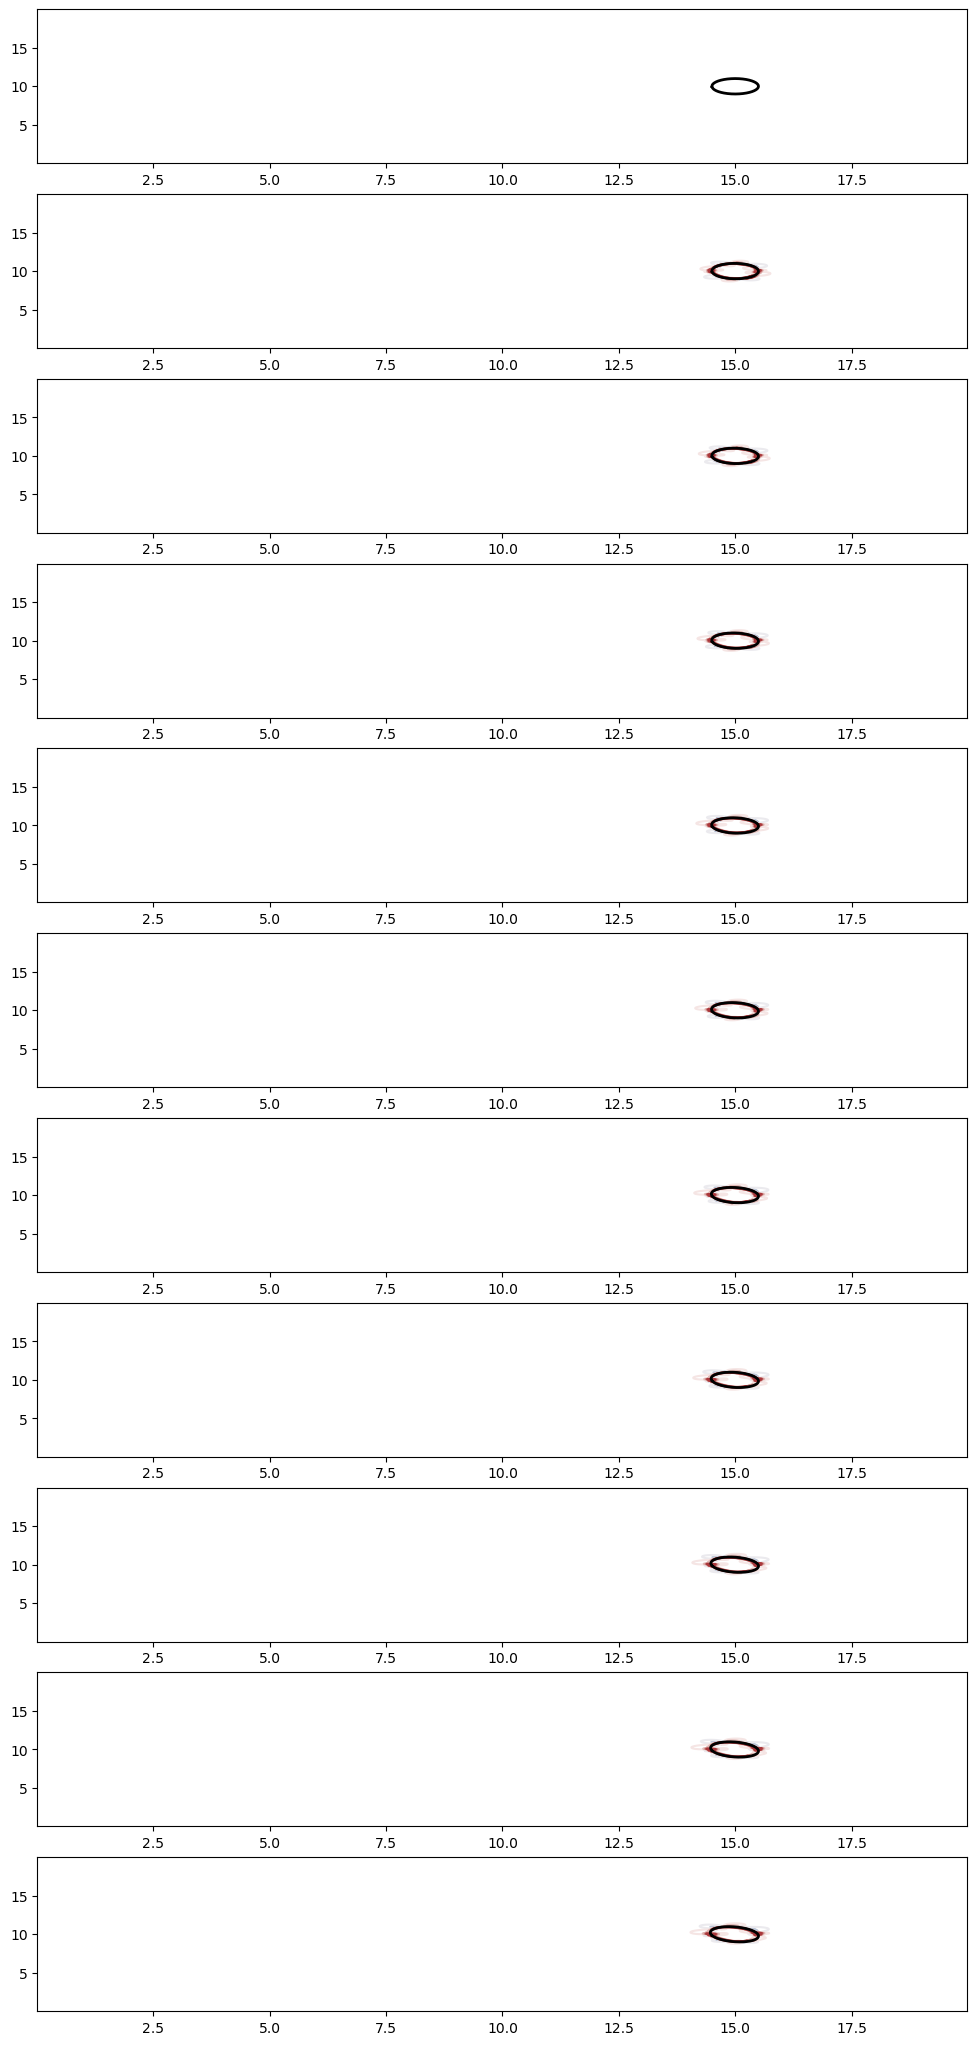

In [68]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity_2(ux, offsetx, uy, offsety, grid, idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(ux[idx], offsetx, grid, 0), vel_bc[0]),
                grids.GridVariable(grids.GridArray(uy[idx], offsety, grid, 0), vel_bc[1]))
    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data


osteps = len(uxs)
print(osteps)
fig,ax = plt.subplots(figsize=(12,26),nrows=osteps)
counter=0
offsetx, offsety = global_velocities[0].offset, global_velocities[1].offset
for idx in range(0,osteps):
    current_t = dt * idx*inner_steps
    ax[counter].contour(X,Y,calc_vorticity_2(uxs, offsetx, uys, offsety, grid, idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1